In [19]:
import os
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import numpy as np

In [17]:
def preprocess_data_v2(pr_folder, ghi_folder, output_csv):
    # Read all GHI data
    ghi_data = []
    for root, _, files in os.walk(ghi_folder):
        for file in files:
            if file.endswith(".csv"):
                filepath = os.path.join(root, file)
                df = pd.read_csv(filepath)
                if 'Date' in df.columns and df.shape[1] == 2:
                    df = df.rename(columns={df.columns[1]: 'GHI'})
                    ghi_data.append(df)
    
    ghi_df = pd.concat(ghi_data, ignore_index=True)

    # Read all PR data
    pr_data = []
    for root, _, files in os.walk(pr_folder):
        for file in files:
            if file.endswith(".csv"):
                filepath = os.path.join(root, file)
                df = pd.read_csv(filepath)
                if 'Date' in df.columns and df.shape[1] == 2:
                    df = df.rename(columns={df.columns[1]: 'PR'})
                    pr_data.append(df)
    
    pr_df = pd.concat(pr_data, ignore_index=True)

    # Merge on 'Date'
    final_df = pd.merge(ghi_df, pr_df, on='Date', how='inner')
    final_df = final_df.sort_values('Date').reset_index(drop=True)

    # Save CSV
    final_df.to_csv(output_csv, index=False)
    print(f"✅ Preprocessed data saved to {output_csv} with {len(final_df)} rows.")
    return final_df


In [18]:
preprocess_data_v2("PR", "GHI", "final_data.csv")


✅ Preprocessed data saved to final_data.csv with 982 rows.


,Date,GHI,PR
0,2019-07-01,3.256608,69.575676
1,2019-07-02,3.976767,79.314411
2,2019-07-03,2.811867,61.020006
3,2019-07-04,3.658408,83.262576
4,2019-07-05,5.590683,82.124440
...,...,...,...
977,2022-03-20,4.226183,81.632738
978,2022-03-21,3.431675,71.057353
979,2022-03-22,3.580492,81.631509
980,2022-03-23,4.997617,71.906149


In [40]:
def plot_pr_graph(csv_file, start_date=None, end_date=None):
    # Load data
    df = pd.read_csv(csv_file)

    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Optional date filtering
    if start_date:
        df = df[df['Date'] >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df['Date'] <= pd.to_datetime(end_date)]

    df = df.sort_values('Date').reset_index(drop=True)

    # 30-day PR moving average
    df['PR_30MA'] = df['PR'].rolling(window=30, min_periods=1).mean()

    # Budget PR decay (0.8% per year starting July 2019)
    initial_budget = 73.9
    annual_decay = 0.008
    budget_dict = {}

    min_date = df['Date'].min()
    max_date = df['Date'].max()

    # Build budget PR range dictionary for each July-June year
    current_year = 2019
    budget_value = initial_budget

    while pd.Timestamp(f'{current_year + 1}-06-30') <= max_date + pd.Timedelta(days=365):
        start = pd.Timestamp(f'{current_year}-07-01')
        end = pd.Timestamp(f'{current_year + 1}-06-30')
        budget_dict[(start, end)] = budget_value
        budget_value *= (1 - annual_decay)
        current_year += 1

    # Map dates to budget PR
    def get_budget_pr(date):
        for (start, end), val in budget_dict.items():
            if start <= date <= end:
                return val
        return budget_value

    df['Budget_PR'] = df['Date'].apply(get_budget_pr)
    total_points=df['PR'].count()
    points_above_budget = (df['PR'] > df['Budget_PR']).sum()

    # GHI-based color coding
    def ghi_color(val):
        if val < 2:
            return 'navy'
        elif 2 <= val <= 4:
            return 'lightblue'
        elif 4 < val <= 6:
            return 'orange'
        else:
            return 'brown'

    df['Color'] = df['GHI'].apply(ghi_color)

    # Plotting
    plt.figure(figsize=(14, 8))
    plt.scatter(df['Date'], df['PR'], c=df['Color'], label='Daily PR', edgecolor='k', alpha=0.7)
    plt.plot(df['Date'], df['PR_30MA'], color='red', linewidth=2, label='30-Day PR Moving Avg')
    plt.plot(df['Date'], df['Budget_PR'], color='darkgreen', linewidth=2, label='Budget PR')

    # GHI color legend
    ghi_legend = [
        Line2D([0], [0], marker='o', color='w', label='GHI < 2', markerfacecolor='navy', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='GHI 2–4', markerfacecolor='lightblue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='GHI 4–6', markerfacecolor='orange', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='GHI > 6', markerfacecolor='brown', markersize=10),
    ]

    plt.legend(handles=ghi_legend + plt.gca().get_legend_handles_labels()[0], loc='upper right')

    # Annotations: PR averages
    avg7 = df['PR'].tail(7).mean()
    avg30 = df['PR'].tail(30).mean()
    avg60 = df['PR'].tail(60).mean()
    avg90= df['PR'].tail(90).mean()
    avg365=df['PR'].tail(365).mean()
    avgLife=df['PR'].mean()
    annotation = f"Points above Target Budget PR : {points_above_budget}/{total_points} : {points_above_budget/(total_points*0.01):.2f}%\nAverage PR last 7-days: {avg7:.2f} \n Average PR last 30-days: {avg30:.2f} \n Average PR last 60-days: {avg60:.2f}  \n Average PR last 90-days: {avg90:.2f}  \n Average PR last 365-days: {avg365:.2f} \nAverage PR Lifetime: {avgLife:.2f}"

    # Place annotation in bottom right
    plt.text(df['Date'].iloc[-1], df['PR'].min(), annotation,
             fontsize=12, verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.title("Performance Ratio (PR) Visualization", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("PR")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example:
# plot_pr_graph("final_data.csv")
#plot_pr_graph("final_data.csv", start_date="2022-01-01", end_date="2023-06-30")

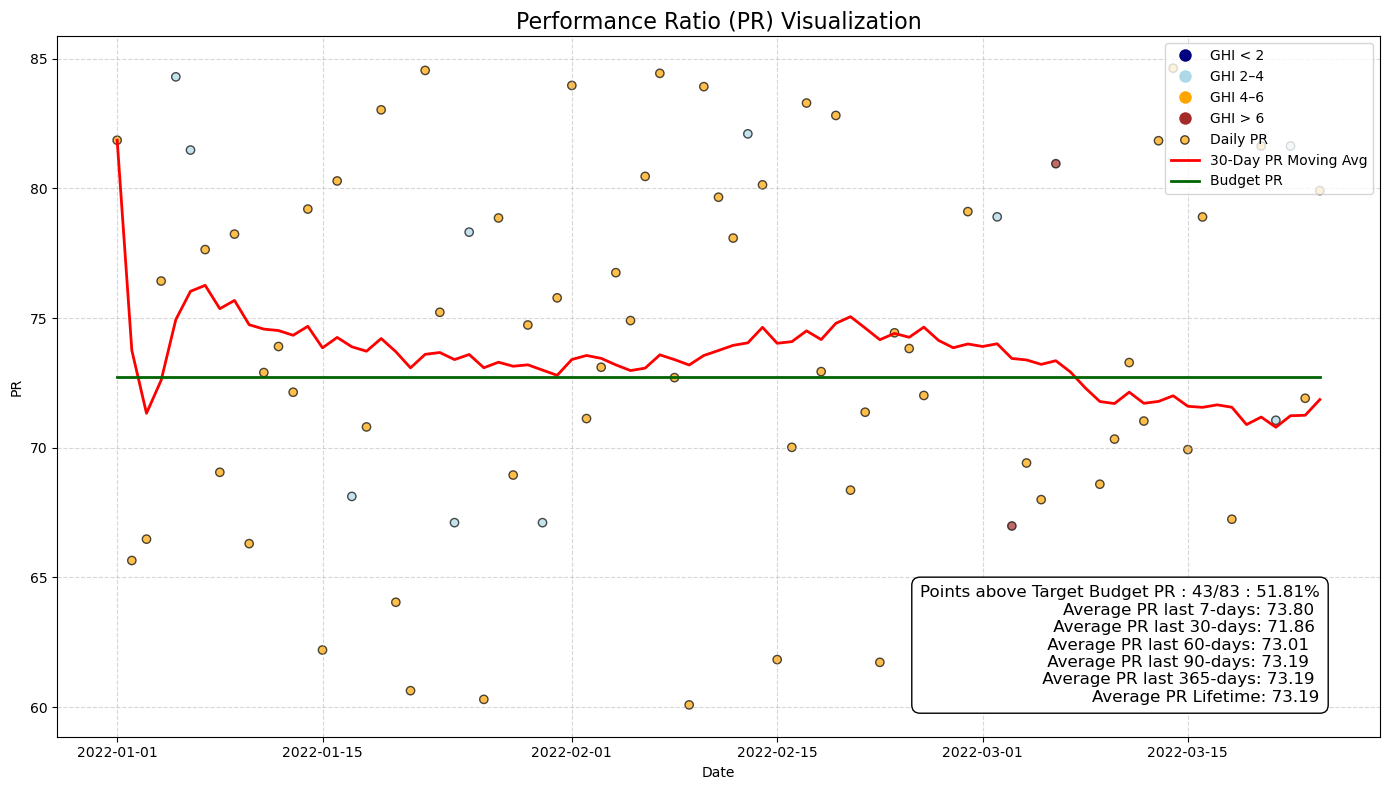

In [41]:
plot_pr_graph("final_data.csv", start_date="2022-01-01", end_date="2023-06-30")

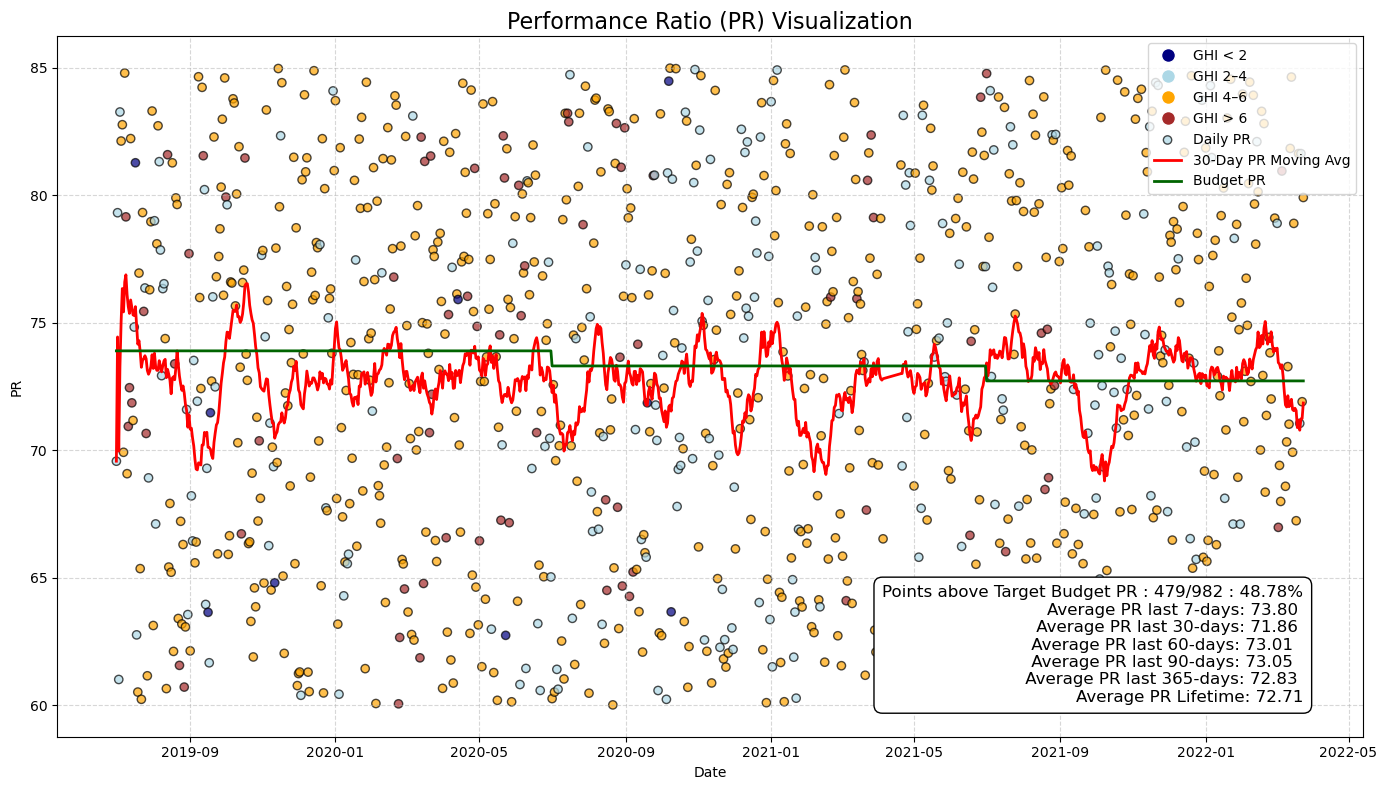

In [42]:
plot_pr_graph("final_data.csv")